# Machine learning avec les modules Python tensorflow2/keras 

## Entraînement / exploitation d'un réseau de neurones dense pour la reconnaissance de chiffres manuscrits

## La banque d'images MNIST

Dans ce TP nous utilisons les images labelisées de la banque MNIST disponible sur Internet (http://yann.lecun.com/exdb/mnist/).

La banque MNIST contient 70000 images en ton de gris de 28 $\times$ 28 pixels, correspondant à des matrice 28 $\times$ 28 de nombres `uint8` (entiers positifs dans l'intervalle [0 ; 255]).<br>
Les 70000 images du MNIST sont regoupées en un jeu de **60000 images d'apprentissage** et un jeu de **10000 images de test**.

<div class="alert alert-block alert-danger">
L'évaluation des performances d'un réseau entraîné doit se faire sur un jeu de données différent du jeu d'entraînement : c'est pour cela que la banque MNIST propose 10000 images de test différentes des 60000 images d'entraînement.
</div>
<p style="text-align:center; font-style:italic; font-size:12px;">
<img src="img/MNIST_digits_sample.png" width="500"><br>
[crédit image : JLC]
</p>

# C/ Travail à faire

## Environnement Python de travail

<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:normal"> 
L'état de l'art actuel des projets de machine learning sous Python préconise l'utilisation d'un <span style="font-weight:bold;">environnement virtuel Python</span> qui permet de maîtriser pour chaque projet les versions de l'interpréteur et des modules Python "sensibles" (comme tensorflow par exemple).

Dans le cas d'un démarrage de l'ordinateur avec une clef USB Ubuntu, on peut considérer que la clef fournit un environnement Python dédié, à condition de ne pas faire de mises à jour des paquets Python avec <span style="font-style:italic">pip install...</span>
    
Dans le cas contraire, la <A href="https://learn.e.ros4.pro/fr/faq/python3/venv/">FAQ Python</A> explique comment créer et utiliser un EVP basé sur **miniconda3** pour utiliser numpy et tensorflow2 avec la bibliothèque optimisée <A href="https://software.intel.com/content/www/us/en/develop/tools/oneapi/components/onemkl.html">MKL</A>.
</span>
</div>

In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
from tensorflow import keras
import sys, cv2
print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} incluant keras {keras.__version__}")
print(f"OpenCV    : {cv2.__version__}")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


2025-02-27 18:46:39.604401: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 18:46:39.617223: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 18:46:39.627434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-27 18:46:39.644085: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-27 18:46:39.644110: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 18:46:39.654632: I tensorflow/core/platform/cpu_feature_guard.cc:

Python    : 3.12.3
tensorflow: 2.16.2 incluant keras 3.8.0
OpenCV    : 4.11.0


Incrustation des tracés matplotlib dans le notebook et import de modules utiles :

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Reproductibilité des générateurs pseudo-aléatoires

Les poids d'un réseau de neurones sont initialisés par tirage aléatoire ; lorsqu'on invoque plusieurs fois de suite des générateurs pseudo-aléatoires on obtient une séquence aléatoire différente à chaque invocation. Par exemple avec `numpy.random.rand` :

In [3]:
import numpy as np
print(np.random.rand(4))

[0.66412642 0.59248207 0.72112475 0.32724287]


In [4]:
print(np.random.rand(4))

[0.19204915 0.84805671 0.62519747 0.2289254 ]


Ce comportement peut être gênant pour étudier les performances d'un réseau entraîné en fonction des paramètres de construction ou d'entraînement : à chaque fois qu'on exécute la cellule ou le notebook avec de nouvelles valeurs des paramètres, on risque d'obtenir un état initial du réseau différent, conduisant à un état du réseau entraîné différent... ce qui peut gêner les comparaisons.

La technique pour éviter ce phénomène consiste à fixer la **graine** (*seed*) des générateurs aléatoires de façon à produire des **séquences aléatoires reproductibles**.<br>

Les cellules suivantes illustrent le mécanisme :

In [5]:
SEED = 43

In [6]:
np.random.seed(SEED)
np.random.rand(5)

array([0.11505457, 0.60906654, 0.13339096, 0.24058962, 0.32713906])

In [7]:
np.random.seed(SEED)
np.random.rand(5)

array([0.11505457, 0.60906654, 0.13339096, 0.24058962, 0.32713906])

Pour appliquer ce mécanisme aux calculs faits avec tensorflow, on pourra utiliser la fonction `set_seed` (cf page [tf.random.set_seed](https://www.tensorflow.org/api_docs/python/tf/random/set_seed)) :
**`tf.random.set_seed(SEED)`**

## 1 - Récupération des images MNIST

Consulter la documentation de la fonction `load_data` sur la page [tf.keras.datasets.mnist.load_data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data) puis compléter la cellule ci-dessous pour charger les données du MNIST en nommant les données renvoyées :<br>
- `im_train`, `lab_train` pour les images et les labels d'entraînement,
- `im_test`, `lab_test` pour les images et les labels de test.

(En cas de message d'erreur de type _"SSL error...."_ pour téléchager les données du MNIST, voir [Python SSL Certification Problems in Tensorflow](https://stackoverflow.com/questions/46858630/python-ssl-certification-problems-in-tensorflow))

In [8]:
(im_train, lab_train), (im_test, lab_test) = tf.keras.datasets.mnist.load_data()

La cellule ci-dessous affiche les attributs `shape` et `dtype` des tableaux numpy obtenus : les valeurs sont-elles cohérentes ? pourquoi ?

In [9]:
print("im_train -> shape:", im_train.shape, ", dtype:", im_train.dtype,)
print("im_test  -> shape:", im_test.shape,  ", dtype:", im_test.dtype,)
print("lab_train-> shape:", lab_train.shape,  ", dtype:", lab_train.dtype)
print("lab_test -> shape:", lab_test.shape,  ", dtype:", lab_test.dtype)

im_train -> shape: (60000, 28, 28) , dtype: uint8
im_test  -> shape: (10000, 28, 28) , dtype: uint8
lab_train-> shape: (60000,) , dtype: uint8
lab_test -> shape: (10000,) , dtype: uint8


### Visualisation des images et des étiquettes :

Avec la fonction `imshow` du module `matplotlib.pyplot` faire afficher en tons de gris la 601-ème image du tableau `im_train`.<br>
Indications :
- utiliser `plt.figure(figsize=(2,2))` pour fixer la taille de l'image
- utiliser l'option `cmap='gray'` de `imshow` pour l'affichage en ton de gris
- enlever les graduations en X et Y (par exemple avec `plt.xticks([]); plt.yticks([])`).

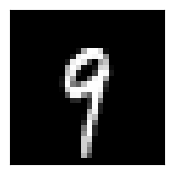

In [10]:
plt.figure(figsize=(2,2))
plt.imshow(im_train[600], cmap='gray')
plt.xticks([]); plt.yticks([]);

Vérifier que le label MNIST associé à `im_train[600]` correspond bien à ce qu'on voir sur l'image....

In [11]:
lab_train[600]

9

La fonction `plot_images` définie ci-dessous prends les arguments `(images, r, L, C)` : elle affiche les images du tableau `images` (tableau de matrices) dans une grille d'images de `L` lignes et `C` colonnes  en commençant avec l'image de rang `r`.

In [24]:
def plot_images(images, r,L,C):
    plt.figure(figsize=(C,L))
    for i in range(L*C):
        plt.subplot(L, C, i+1)
        plt.imshow(255-images[r+i], cmap='gray')
        plt.xticks([]); plt.yticks([])
        #plt.box(False)

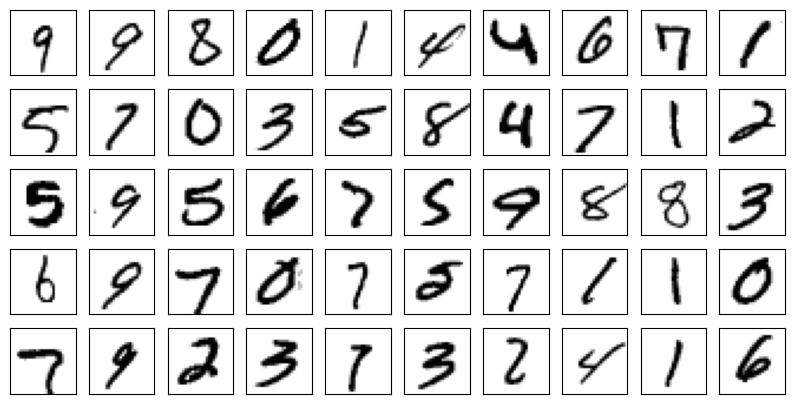

In [25]:
plot_images(im_train, 600, 5, 10)

In [16]:
def plot_images(images, r,L,C):
    plt.figure(figsize=(C,L))
    for i in range(L*C):
        plt.subplot(L, C, i+1)
        plt.imshow(images[r+i], cmap='gray')
        plt.xticks([]); plt.yticks([])

Faire afficher les images d'entraînement à partir de la 601 ème dans une grille de 4 x 6 :

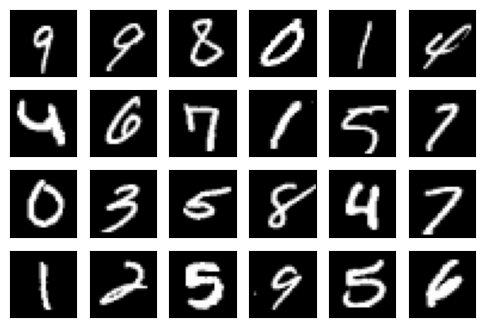

In [13]:
plot_images(im_train, 600, 4, 6)

Dans la cellule ci-dessous, on trie les images et on affiche des lignes de '0', des lignes de '1'... en noir sur fond blanc :

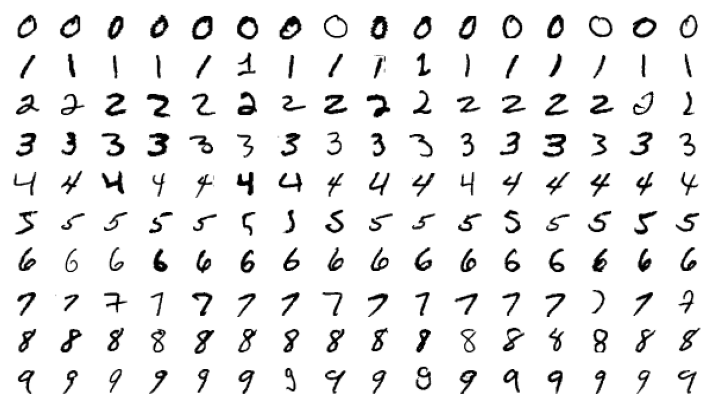

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
L, C = len(data), len(data[0])
for row, digits in enumerate(data):
    for col, digit in enumerate(digits):
        plt.subplot(L, C , row*C + col + 1)
        plt.imshow(255-digit, cmap='gray')
        plt.xticks([]); plt.yticks([])
        plt.box(False)
plt.show()        

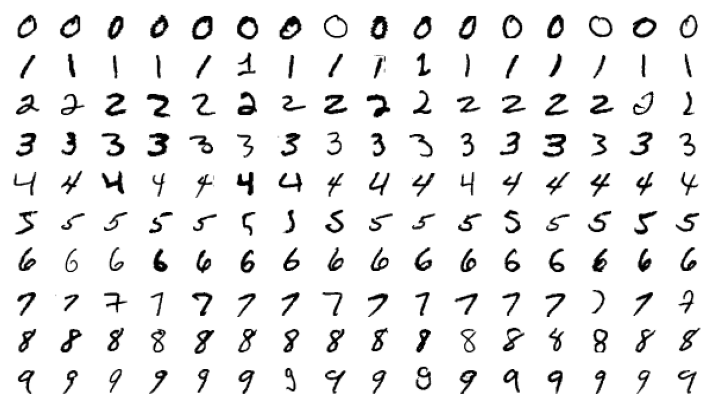

In [14]:
import matplotlib.pyplot as plt

data = []
for i in range(10):
    indexes = np.where(lab_train == i) # indices des labels égaux à i
    i_data = im_train[indexes][:16]    # tableau des images correspondates
    data.append(i_data)

plt.figure(figsize=(9,5))
L, C = len(data), len(data[0])
for row, digits in enumerate(data):
    for col, digit in enumerate(digits):
        plt.subplot(L, C , row*C + col + 1)
        plt.imshow(255-digit, cmap='gray')
        plt.xticks([]); plt.yticks([])
        plt.box(False)
plt.show()        

## Pré-traitement des données MNIST

Pour adapter les données à la couche d'entrée du réseau de neurones, on transforme les matrice d'entiers `uint8` représentant les images 28x28 pixels en vecteurs **normalisés** $(V_i)_{i=0..783}$ de 784 valeurs réelles $V_i$  avec $ 0 \leqslant V_i \leqslant 1$.

### Transformation des matrices d'entrée en vecteurs normalisés :

Pour éviter de "claquer en dur" le nombre d'images d'entraînement et de test ainsi que la dimension des images, on récupère ces paramètres :
- avec l'attribut `shape` des tableaux `im_train` et `im_test`
- avec l'attribut `size` de la première image d'entraînement par exemple

In [15]:
nb_im_train = im_train.shape[0]    # nombre d'images d'entraînement
nb_im_test  = im_test.shape[0]     # nombre d'images de test 
nb_pixel    = im_train[0].size     # nombre d'éléments (des pixels) de la première image 

Vérification :

In [16]:
print(f"{nb_im_train} images d'entraînement et {nb_im_test} images de test")
print(f"{nb_pixel} pixels dans chaque image")

60000 images d'entraînement et 10000 images de test
784 pixels dans chaque image


Définir maintenant les tableaux `x_train` et `x_test` contenant les matrices des tableaux `im_train` et `im_test` *mises à plat* sous forme de vecteurs normalisés (valeurs comprises entre 0 et 1).<br>
*indications* : utiliser la méthode `reshape` des tableaux ndarray de numpy et les paramètres `nb_im_train`, `nb_im_test` et `nb_pixel` calculés précédemment :

In [17]:
x_train = im_train.reshape(nb_im_train, nb_pixel)/im_train.max()
x_test  = im_test.reshape(nb_im_test, nb_pixel)/im_test.max()

Vérifier les dimensions des tableaux `x_train` et `x_test` :

In [18]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

Vérifier que les valeurs min et max des tableaux `x_train` et `x_test` sont bien celles attendues :

In [19]:
x_train.min(), x_train.max()

(np.float64(0.0), np.float64(1.0))

In [20]:
x_test.min(), x_test.max()

(np.float64(0.0), np.float64(1.0))

###  Codage *one-hot*  des labels:

Consulter la documentation de la fonction `to_categorical` sur la page [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)  et en déduire comment définir les tableaux `y_train` et `y_test` contenant la version encodée *hot-one* des tableaux `lab_train` et `lab_test` :

In [21]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' des labels :
y_train = to_categorical(lab_train)
y_test  = to_categorical(lab_test)

Vérifier visuellement les 10 premières valeurs des tableaux `lab_train` et `y_train` :

In [23]:
print(lab_train[:10])
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## 3 - Construction du réseau de neurones

On va maintenant construire un réseau de neurones **séquentiel** en **5 lignes** Python à l'aide du module **keras**.

Après lecture de la page [guide/keras/sequential_model](https://www.tensorflow.org/guide/keras/sequential_model), construire le réseau  de façon incrémentale (méthode `add`) dans la cellule ci-dessous en suivant la démarche proposée :
- 1/ Créer l'objet `model` instance de la classe `Sequential` (cf [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)).
- 2/ Ajouter la couche d'entrée `Input(shape=<nombre de neurones>)` (cf [tf.keras.layers.InputLayer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer)) pour spécifier la forme des données d'entrée. Utiliser le paramètre `nb_pixels`...<br>
- 3/ Ajouter les autres couches `Dense` (cf [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) :
    - couche 1 : `Dense(<nombre de neurones>, activation='relu')` (cf [tf.keras.activation.relu](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu))
    - couche 2 : `Dense(<nombre de neurones>, activation='softmax')` (cf [tf.keras.activation.softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax)).<br>
On pourra utiliser les paramètres `nb_pixels` et `nb_classes` pour indiquer le nombre de neurones sans les 'claquer en dur'...    
- 4/ Une fois construit, le réseau doit être compilé (au sens de tensorflow) avec la méthode `compile` et les arguments :
    - `loss='categorical_crossentropy'` : choix de la fonction d'erreur (cf [tf.keras.categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy))
    - `optimizer='adam'` : choix de l'optimiseur Adam (cf page [tf.keras.optimizers.Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam))
    - `metrics=['accuracy']` pour obtenir les données permettant de tracer les courbes de performance.

In [24]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

nb_classe = 10
tf.random.set_seed(SEED)

# les 5 lignes pour construire le réseau de neurones:
model = Sequential()
model.add(Input(shape=(nb_pixel,), name='Input'))
model.add(Dense(nb_pixel, activation='relu', name='C1'))
model.add(Dense(nb_classe, activation='softmax', name='C2'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

2025-02-12 20:15:05.698227: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Avec la méthode `summary` de l'objet `model`, faire afficher la description du modèle et vérivhier les dimensions...

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ C1 (Dense)                      │ (None, 784)            │       615,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C2 (Dense)                      │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 623,290 (2.38 MB)

 Trainable params: 623,290 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

Pourquoi y-a-t-il des `None` dans la colonne "Output Shape"  ?

Retrouver le nombre total de paramètres avec une formule simple ...

In [27]:
785*784+785*10

623290

La fonction `plot_model` permet de dessiner la structure du réseau (voir la page [tf.keras.utils.plot_model](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model)).<br>
Faire tracer la structure du modèle en ajoutant l'option `show_shapes=True` à l'appel de `plot_model` :

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


*Remarque* : en utilisant l'argument nommé `name` dans la fonction `Dense`, on peut donner des noms personnalisés aux couches, qui apparaîtront dans les sorties de `summary` et de `plot_model`.

### Sauvegarde de l'état initial du  réseau

On peut sauvegarder l'état initial des poids du réseau non-entraîné (valeurs aléatoires) avec la méthode `save_weights` de la classe `Sequential`. <br>
Ce sera utile plus loin pour remettre le réseau à son état initial avant de relancer d'autres entraînements :

In [32]:
import os

# vérifier que le dossier 'weights' existe et sinon le créer:
if not os.path.isdir("weights"): os.mkdir("weights")

# sauvegarde des poinds du réseau initial:
weight_file = 'model_initial.weights.h5'
model.save_weights('weights/'+weight_file)

# afficher les fichiers créés:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith(key)]
for f in files: print(f)

weights/model_initial.weights.h5


Remarque : la méthode `save_weights` utilise la partie `key` du chemin passé en argument pour préfixer les fichiers créés.<br>
Lors de la lecture ultérieure des poids du réseau avec la méthode `load_weights` de la classe `Sequential`, il suffira de donner la même information pour retrouver les bons fichiers.

## 4 - Entraînement du réseau

Consulter au besoin la documentation de la méthode `fit` sur la page [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).

Compléter la cellule ci-dessous pour entraîner le réseau avec la méthode `fit` de l'objet `model` en utilisant les arguments :
- `x_train` : les 60000 images mises à plat et normalisées
- `y_train` : les 60000 labels encodés *one-hot*.
- `epochs=15` : faire 15 fois l'entraînement complet.
- `batch_size=128` : découper le jeu des données d'entrée (les 60000 images) en "lots" (*batch*) de taille `batch_size` (ici en lots de 128 images).<br>
La mise à jour des poids du réseau est faite au bout de `batch_size` échantillons d'entrée.<br>
La valeur de `batch_size` (par défaut : 32) est un paramètre qui influe sur la qualité de l'apprentissage mais aussi sur son empreinte mémoire : on pourra plus loin essayer différentes (64, 128, 256 ...) et observer comment évolue la qualité de l'entraînement).



In [33]:
# au cas on on exécute plusieurs fois cette cellule, on peut ré-initialiser 
# le réseau à son état initial si on veut comparer les entraînements...
weight_file = 'model_initial.weights.h5'
model.load_weights('weights/' + weight_file)  

hist = model.fit(x_train, y_train, 
                 epochs=5, 
                 batch_size=128)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8769 - loss: 0.4334
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9673 - loss: 0.1119
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9807 - loss: 0.0672
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9872 - loss: 0.0448
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9914 - loss: 0.0312


L'objet `hist` retourné par la méthode `fit` possède un attribut `history` de type `dict` dont les clefs `'loss'` et `'accuracy'` sont associées aux informations correspondantes obtenues après chaque _epoch_ :

In [34]:
hist.history.keys()

dict_keys(['accuracy', 'loss'])

In [35]:
hist.history['loss']

[0.249467670917511,
 0.09833039343357086,
 0.06115201115608215,
 0.041183341294527054,
 0.028353767469525337]

In [36]:
hist.history['accuracy']

[0.928933322429657,
 0.9709833264350891,
 0.9821666479110718,
 0.9884666800498962,
 0.9925166964530945]

### Tracé des courbes `loss` et `accuracy` 

La fonction `plot_loss_accuracy` du module `utils.tools` (présent dans le répertoire du notebook) permet de tracer les courbes "fonction d'erreur" et "précision" sur la base des données stockées dans `hist`.<br> Importer et utiliser la fonction`plot_loss_accuracy` pour faire tracer ces courbes :

In [38]:
from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

ModuleNotFoundError: No module named 'pandas'

### À propos de la reproductibilité de l'entraînement...

la reproductibilité parfaite d'un entraînement de réseau de neurones est parfois difficile à atteindre avec tensorflow....

Observe les résultats des cellules suivantes :


Dans ce premier essai, le réseau est initialisé une fois, puis à chaque tour de boucle il est entraîné sur la base de son état au tour de boule précédent... `loss` et `accuracy` évoluent à chaque tour de boucle.<br>
$\leadsto$ c'est comme si on avait fait un `model.fit(x_train, y_train, epochs=10, batch_size=64)`

In [33]:
# recharger l'état initial du réseau:
key = 'model_initial'
model.load_weights('weights/'+key) 

for _ in range(10):
    hist = model.fit(x_train, y_train, epochs=1, batch_size=64)

938/938 [==============================] - 3s 3ms/step - loss: 0.0076 - accuracy: 0.9975


Dans la cellule suivante, on réinitialise bien l'état initial du réseau **avant chaque lancement de `fit`** : c'est mieux, mais ce n'est pas encore parfait...

In [34]:
for _ in range(10):
    # recharger l'état initial du réseau:
    key = 'model_initial'
    model.load_weights('weights/'+key) 

    hist = model.fit(x_train, y_train, epochs=1, batch_size=64)

938/938 [==============================] - 3s 4ms/step - loss: 0.1933 - accuracy: 0.9430


Et dans cet essai, on ré-initialise la graine tensorflow avec `tf.random.set_seed(SEED)` avant chaque invocation de `fit` : ce n'est toujours pas exactement les mêmes valeurs `loss` et `accuracy` que l'on observe, mais on en est très proche...

In [ ]:
for _ in range(10):
    # recharger l'état initial du réseau:
    key = 'model_initial'
    model.load_weights('weights/'+key) 
    tf.random.set_seed(SEED)
    
    hist = model.fit(x_train, y_train, epochs=1, batch_size=64)

## 5 - Entraînement du réseau avec test à chaque *epoch*

Pour avoir un indicateur réaliste de la qualité du réseau entraîné on peut tester à chaque `epoch` la précison des inférences du réseau entraîné en utilisant les données de test : il suffit de passer l'agument `validation_data` à la méthode `fit`, en lui affectant le tuple des données de test `(x_test, y_test)`

In [ ]:
# recharger l'état initial du réseau:
key = 'model_initial'
model.load_weights('weights/'+key) 
tf.random.set_seed(SEED)

hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test), 
                 epochs=15, 
                 batch_size=128)


On a cette fois dans `hist.history` non seulement les clefs `loss` et `accuracy` mais aussi `val_loss` et `val_accuracy` calculées avec les données de test :

In [ ]:
hist.history.keys()

Faire afficher ces courbes avec la fonction `plot_loss_accuracy` :

In [ ]:
plot_loss_accuracy(hist)

On voit que la précision calculée avec les données de test tend vers une limite voisine de 98%. <br>
On pourrait penser qu'augmenter la valeur de `epochs` permet d'améliorer la précision du réseau... mais on court le risque de sur-entraînner le réseau (*over-fit*).

### Arrêter automatiquement l'entraînement avant *over-fit*

Keras propose des outils pour arrêter automatiquement l'apprentissage en surveillant par exemple la croissance de la précision d'une `epoch` à l'autre (cf le callback  [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)).


On peut ainsi définir une liste de fonctions *callback* que l'on peut passer en argument à la fonction `fit` avec l'agument nommé  `callbacks` :

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks_list = [ 
    EarlyStopping(monitor='val_accuracy',  # la grandeur à surveiller
                  patience=2,              # accepter que 'val_accuracy' diminue 2 fois en tout
                  mode='max',              # arrêter si le paramètre décroît 
                  restore_best_weights=True,
                  verbose=1)
]

# recharger l'état initial du réseau:
key = 'model_initial'
model.load_weights('weights/'+key) 
tf.random.set_seed(SEED)

hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 epochs=15, 
                 batch_size=128, 
                 callbacks = callbacks_list)

from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

Au lieu de surveiller la croissance du paramètre `val_accuracy`, on peut surveiller la décroissance de `val_loss` :

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks_list = [ 
    EarlyStopping(monitor='val_loss',  # la grandeur à surveiller
                  patience=2,          # accepter que 'val_accuracy' diminue 2 fois en tout
                  mode='min',          # arrêter si le paramètre croît 
                  restore_best_weights=True,
                  verbose=1)
]

# recharger l'état initial du réseau:
key = 'model_initial'
model.load_weights('weights/'+key) 
tf.random.set_seed(SEED)

hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 epochs=15, 
                 batch_size=128, 
                 callbacks = callbacks_list)

from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

### Sauvegarder les poids du  réseau entraîné

Pour sauvegarder les **poids** d'un réseau entraïné dans un fichier, on utilise la méthode `save_weights` de la classe `Sequential`:

In [ ]:
import os
# vérifier que le dossier 'weights' existe et sinon le créer:
if not os.path.exists("weights"): os.mkdir("weights")

# sauvegarde des poids du réseau entrainé:
key = 'model_trained'
model.save_weights('weights/'+key)

# afficher les fichiers créés:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith(key)]
for f in files: print(f)

### Sauvegarder la structure du réseau et ses poids

La méthode `save` de la classe `Sequential` permet d'enregistrer dans des fichiers **toute la structure et les poids** du réseau entraïné.<br />
$\leadsto$ Ceci permet de recréer plus tard *from scratch* le réseau entrainé pour passer en phase exploitation du réseau par exemple, en utilisant la fonction`tf.keras.models.load_model` :

In [ ]:
import os
# vérifier que le dossier 'weights' existe et sinon le créer:
if not os.path.exists("models"): os.mkdir("models")

# sauvegarder structure réseau + poids :
key = 'model'
model.save('models/'+key) 

# afficher les fichiers créés:
files=[os.path.join("models",f) for f in os.listdir("models") if f.startswith(key)]
for f in files: print(f)

## 6/ Exploitation du réseau avec le jeu de test

La méthode `predict` de l'objet `model` permet de calculer les inférences du réseau pour une ou plusieurs entrées (voir la méthode `predict`dans la page [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)).

La cellule ci-dessous montre la mise en oeuvre de la méthode `predict`, et comment exploiter la représentation  *one-hot* renvoyée par `fit` en utilisant la méthode `argmax` des tableaux de numpy :

In [ ]:
i = 100   # numéro image de test
rep = model.predict(x_test[i:i+1]) # Attention: x doit être un tableau de matrices...
                                   # => x[i] ne convient pas !

print(f"sortie one-hot du réseau pour l'image de rang {i} :\n{rep[0]}")

# limiter l'affichage des composantes des tableaux numpy à 1 chiffre :    
with np.printoptions(formatter={'float':'{:.1f}'.format}):    
    print(f"\nsortie one-hot réseau arrondie à 1 chiffre : {rep[0]}")
    
print(f"rep[0].argmax() donne : {rep[0].argmax()}")

print(f"\nLa bonne réponse est {lab_test[i]} soit en 'one-hot' : {y_test[i]}")

plot_images(im_test,i,1,1)

#### Utilité de la méthode `ndarray.argmax` de numpy pour décoder le tableau de vecteurs *one-hot* renvoyé par la méthode `predict`

Quand on calcule une inférence du réseau `model` avec les données de test par exemple, on obtient un résultat qui est un tableau de vecteurs codés *one-hot*, comme le détaille la cellue suivante :

In [ ]:
results = model.predict(x_test)

print("forme du tableau 'results':", results.shape)
print("allure des vecteurs du tableau 'result', par exemple :")
with np.printoptions(formatter={'float':'{:.4f}'.format}): 
    print("results[0]  :", results[0])
    print("results[-1] :", results[-1])

En écrivant `results.argmax(axe=-1)`, on obtient le tableau des `argmax` de chaque vecteur -> c'est directement le tableau des chiffres reconnus par le réseau :

In [ ]:
chiffres_reconnus = results.argmax(axis=-1)

print("chiffres_reconnus -> shape:", chiffres_reconnus.shape, ", dtype:", chiffres_reconnus.dtype)
print(f"contenu de chiffres_reconnus : {chiffres_reconnus}")

Retrouver le taux de réussite du réseau entrainé en utilisant les inférences du réseau pour les entrées `x_test` et les labels `lab_test` :

In [ ]:
results = model.predict(x_test)
chiffres_reconnus = results.argmax(axis=-1)

success = 0
for chiffre, label in zip(chiffres_reconnus, lab_test):
    success += (chiffre == label)
print(f"taux de réussite : {success/len(x_test)*100:.2f} %")

###  Afficher la matrice de confusion

La cellule suivante définie la fonction `show_cm_mnist` qui affiche la **matrice de confusion**.

La matrice de confusion permet de visualiser :
- sur la diagonale : les bonnes réponses du réseau, avec dans chaque case le nombre de bonnes réponses
- hors diagonale : les erreurs du réseau, avec dans chaque case la fréquence d'apparition de l'erreur.

In [ ]:
import pandas as pd
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

def show_cm_mnist(target, results, classes):
    # target  : the actual labels (one-hot format)
    # results : the labels computed by the trained network (one-hot format)
    # classes : list of possible label values
    predicted = np.argmax(results, axis=-1) # tableau d'entiers entre 0 et 9 
    cm = confusion_matrix(target, predicted)
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(11,9))
    heatmap(df_cm, annot=True, cbar=False, fmt="4d")
    plt.xlabel('actual label')
    plt.ylabel('predicted label')
    plt.show()

Faire afficher la matrice de confusion en lui passant les labels attendus `lab_test` et les labels calculés par le model :

In [ ]:
show_cm_mnist(lab_test, results, range(nb_classe))

# D/ Bonus

 ## Réseau profond : augmenter le nombre de couches cachées 
 
 On peut essayer de construire un réseau avec plus de couches. Par exemple :
- couche d'entrée avec les 784 pixels
- couche cachée 1 : 500 neurones, fonction d'activation `relu`
- couche cachée 2 : 400 neurones, fonction d'activation `relu`
- couche de sortie : 10 neurone, fonction d'activation `softmax`.

Écrire une fonction paramétrée `build_nn` qui effectue les opérations suivantes:
- Construire un réseau de neurones dense dédié à la reconnaissance des chiffres MNIST avec un nombre de données d'entrée, de neurones par couche et de neurones dans la dernière couche paramétrés.
- Entraîner le réseau avec test à la fin de chaque `epoch` et arrêt automatique basé sur la surveillance de `val_accuracy` .
- Afficher les courbes 'Model Loss' et 'Model accuracy' du réseau entraîné.
- Afficher la matrice de confusion.

Par exemple, pour créer, entraîner et tester le réseau profond suggéré ci-dessus, on pourrait écrire :<br>

    data = (x_train, y_train, x_test, y_test)
    tf.random.set_seed(SEED)
    my_model1 = build_mn(784, (500, 400), 10, data, batch_size=64)

In [ ]:
# définition de la fonction build_nn
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

from utils.tools import plot_loss_accuracy
from utils.tools import show_cm_mnist

def build_nn(nb_input, layers, nb_classe, data, epoch=15, batch_size=64, patience=5):

    x_train, y_train, x_test, y_test = data
        
    model = Sequential()
    model.add(Input(shape=(nb_input,)))
    for nb_neurone in layers:
        model.add(Dense(nb_neurone, activation='relu'))
    model.add(Dense(nb_classe, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    tf.keras.utils.plot_model(model, show_shapes=True)
    
    callbacks_list = [ 
    EarlyStopping(monitor='val_accuracy',  # la grandeur à surveiller
                  patience=patience,       # accepter que 'val_accuracy' diminue 'patience' fois de suite
                  restore_best_weights=True,
                  verbose=1)
    ]

    hist = model.fit(x_train, y_train, 
                     validation_data=(x_test, y_test), 
                     epochs=epoch, 
                     batch_size=batch_size,
                     callbacks=callbacks_list)
    
    plot_loss_accuracy(hist)
    
    show_cm_mnist(lab_test, model.predict(x_test), range(nb_classe))
    
    return model

In [ ]:
# utilisation de build_nn :
data = (x_train, y_train, x_test, y_test)
tf.random.set_seed(SEED)

my_model1 = build_nn(784, (500, 400), 10, data, batch_size=64)

Quel est l'impact de l'augmentation du nombre de couches du réseau ?<br>

## Faire reconnaître des images originales à un réseau entraîné avec les images MNIST

Plusieurs possibilités :
- utiliser des images crées pour l'occasion... 
- utiliser les images toutes prêtes du répertoire `chiffres`.

Si tu crées tes propres images de chiffres écrits à la main, il faut :
- les mettre au format MNIST (28x28 pixels en ton de gris, chiffre centré dans l'image) 
- les placer dans un répertoire spécifique ,
- affecter le nom de ce répertoire à `images_dir` dans la cellule ci-dessous :

In [ ]:
import os

# changer le nom du répertoire au besoin :
images_dir = "chiffres"

images = [os.path.join(images_dir,f) for f in os.listdir(images_dir) if f.endswith(".png")]
images.sort()

print(f"Images du dossier <{images_dir}> à reconnaître :")
for im in images: print(im)

### Lecture des fichiers image avec openCV

Les images doivent être convertie en images en ton de gris de 28 x 28 pixels pour pouvoir être traitées par le réseau entraîné sur les images MNIST.

Plusieurs fonctions du module OpenCV pourront être utilisées :
- `cv2.imread(file_name)` : pour lire un fichier image aux formats standards (PNG, JPG,...)
- `cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)` : pour convertir le tableau `img` renvoyé par `cv2.imread` en tons de gris
- `cv2.resize` : pour retailler l'image.

La cellule ci-dessous montre un exemple de lecture et traitement avec OpenCV des images du dossier `chiffres` qui sont déjà au format 28 x 28 pixe :

In [ ]:
import cv2
my_images = []
for image_path in images:
    img = cv2.imread(image_path)                    # lecture fichier image
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # conversion en tons de gris
    my_images.append(img_gray)

Visualisation des images lues :

In [ ]:
plot_images(my_images, 0, 1, 10)

Inversion des images pour avoir des chiffres doivent être en blanc sur fond noir :

In [ ]:
my_images = [255 - im for im in my_images]
plot_images(my_images, 0, 1, 10)

On peut maintenant :
- transformer des matrices 28x28 en vecteurs de float normalisés,
- calculer les inférences du réseau entaîné de votre choix (`model` ou `my_model1` ou autre...) avec les images perso en entrée,
- faire afficher la précision obtenue et la matric de confusion.

In [ ]:
my_images = np.array(my_images)

nb_images = my_images.shape[0]
nb_pixel  = my_images[0].size

# mise 'à plat' des matrices sous forme de vecteurs de floats normalisés :
my_x = my_images.reshape(nb_images, nb_pixel)/255.

#### Inférences du réseau `model` avec les images perso et affichage de la matrice de confusion :

In [ ]:
my_results = model.predict(my_x)
print(my_results.argmax(axis=-1))
target    = np.array([0,1,2,3,4,5,6,7,8,9])  # les réponses qu'on devrait avoir
show_cm_mnist(target, my_results, range(10))

#### Inférences du réseau `my_model1` avec les images perso et affichage de la matrice de confusion :

In [ ]:
my_results = my_model1.predict(my_x)
print(my_results.argmax(axis=-1))
target    = np.array([0,1,2,3,4,5,6,7,8,9]) # les réponses qu'on devrait avoir
show_cm_mnist(target, my_results, range(10))

Pour conclure avec les images perso il faudrait bien sûr faire des tests avec un plus grand nombre d'images....

Les résultats obtenus suggèrent :
- que le réseau à 1 couche cachée et à plusieurs couches cachées donnent des performances proches pour les images MNIST,
- que l'apprentissage d'un réseau dense reste assez sensible à la nature du jeu de données : les images de chiffres 'maison' ne ressemblent pas tout à fait à celles de la banque MNIST, d'où des erreurs de classification avec un simple réseau dense.

# La suite....

Pour aller au-delà des 98% de reconnaissance des chiffres MNIST et une meilleure reconnaissance des 'images perso', il faut passer à une architecture de réseau plus adaptée au traitement des images : les réseaux **convolutionnels**, traités dans le notebook `TP3_MNIST_convol.ipynb`.

# Autres ressources intéressantes... des vidéos :

In [1]:
%%HTML
<iframe src="https://www.youtube.com/embed/trWrEWfhTVg" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [2]:
%%HTML
<iframe src="https://www.youtube.com/embed/aircAruvnKk" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [3]:
%%HTML
<iframe src="https://www.youtube.com/embed/IHZwWFHWa-w" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [4]:
%%HTML
<iframe src="https://www.youtube.com/embed/Ilg3gGewQ5U" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>